In [12]:
import sys
sys.path.append('..')

import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io
from shapely.geometry import Polygon

import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

from dataset_preparing import get_coords_from_densifing_points, generate_heatmap

def min_max_normalize(image, percentile, nodata=-1.):
    image = image.astype('float32')
    mask = np.mean(image, axis=2) != nodata * image.shape[2]

    percent_min = np.percentile(image, percentile, axis=(0, 1))
    percent_max = np.percentile(image, 100-percentile, axis=(0, 1))

    if image.shape[1] * image.shape[0] - np.sum(mask) > 0:
        mdata = np.ma.masked_equal(image, nodata, copy=False)
        mdata = np.ma.filled(mdata, np.nan)
        percent_min = np.nanpercentile(mdata, percentile, axis=(0, 1))

    norm = (image-percent_min) / (percent_max - percent_min)
    norm[norm < 0] = 0
    norm[norm > 1] = 1
    norm = (norm * 255).astype('uint8') * mask[:, :, np.newaxis]

    return norm


def image_graph_collate_road_network_coco(batch):
    images = torch.stack([item['image'] for item in batch], 0).contiguous()
    heatmap = torch.stack([item['heatmap'] for item in batch], 0).contiguous()
    points = [item['nodes'] for item in batch]
    edges = [item['edges'] for item in batch]

    return [images, heatmap, points, edges]


def create_polygon(segmentation):
    # COCO segmentation format is [x1, y1, x2, y2, ..., xn, yn]
    # We need to reshape it to [(x1, y1), (x2, y2), ..., (xn, yn)]
    points = list(zip(segmentation[::2], segmentation[1::2]))
    return Polygon(points)


def gdf_to_nodes_and_edges(gdf):
    nodes = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            for x, y in polygon.exterior.coords:
                nodes.append((x, y))
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                for x, y in part.exterior.coords:
                    nodes.append((x, y))
        else:
            raise AttributeError

    # Remove duplicates if necessary
    nodes = list(set(nodes))

    # Create a DataFrame for nodes with unique indices
    node_df = pd.DataFrame(nodes, columns=['x', 'y'])
    node_df['node_id'] = range(len(node_df))

    edges = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            coords = polygon.exterior.coords[:-1]  # Exclude closing vertex
            edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                    node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                    for i, (x, y) in enumerate(coords)]
            edges.extend(edge)
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                coords = part.exterior.coords[:-1]
                edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                        node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                        for i, (x, y) in enumerate(coords)]
                edges.extend(edge)

    return node_df[['y', 'x']].values, edges


class CrowdAI(Dataset):
    """A dataset class for handling and processing data from the CrowdAI dataset.

    Attributes:
        IMAGES_DIRECTORY (str): Directory containing the images.
        ANNOTATIONS_PATH (str): File path for the annotations.
        coco (COCO): COCO object to handle COCO annotations.
        max_points (int): Maximum number of points to consider (default 256).
        gap_distance (float): Distance between interpolated points.
        sigma (float): Standard deviation for Gaussian kernel used in heatmap generation.

    Args:
        images_directory (str): Directory where the dataset images are stored.
        annotations_path (str): File path for the COCO format annotations.
        gap_distance (int, optional): Gap distance for densifying points. Defaults to 20.
        sigma (float, optional): Sigma value for Gaussian blur in heatmap. Defaults to 1.5.
    """

    def __init__(self, 
                 images_directory, 
                 annotations_path,
                 gap_datance=20,
                 sigma=1.5):

        self.IMAGES_DIRECTORY = images_directory
        self.ANNOTATIONS_PATH = annotations_path
        self.coco = COCO(self.ANNOTATIONS_PATH)
        self.image_ids = self.coco.getImgIds(catIds=self.coco.getCatIds())

        self.len = len(self.image_ids)

        self.max_points = 256 # TODO: It should be restricted the number when gt points over the max points limit
        self.gap_distance = gap_datance
        self.sigma = sigma

    def prepare_annotations(self, img):
        """Prepares annotations for an image.
        Args:
            img (dict): A dictionary containing image metadata.

        Returns:
            GeoDataFrame: A GeoDataFrame containing the geometrical data of annotations.
        """
        annotation_ids = self.coco.getAnnIds(imgIds=img['id'])
        annotations = self.coco.loadAnns(annotation_ids)
        random.shuffle(annotations)

        data = []
        for ann in annotations:
            polygon = create_polygon(ann['segmentation'][0])
            data.append({'id': ann['id'], 'geometry': polygon})
        gdf = gpd.GeoDataFrame(data, geometry='geometry')
        return gdf

    def loadSample(self, idx):
        """Loads a sample for a given index.

        Args:
            idx (int): The index of the sample to load.

        Returns:
            dict: A dictionary containing the sample data.
                'image' (torch.Tensor of shape [3, H, W], torch.float32): 
                    The image tensor normalized to [0, 1].
                'image_idx' (torch.Tensor of shape [1], torch.long): 
                    The index of the image.
                'heatmap' (torch.Tensor of shape [H, W], torch.float32): 
                    The heatmap tensor for the image normalized to [0, 1]. 
                'nodes' (torch.Tensor of shape [N, 2], torch.float): 
                    The nodes tensor representing points in the image.
                    nodes are normalized to [0, 1]
                'edges' (torch.Tensor of shape [E, 2], torch.long): 
                    The edges tensor representing connections between nodes.
        """
        idx = self.image_ids[idx]

        img = self.coco.loadImgs(idx)[0]
        image_path = os.path.join(self.IMAGES_DIRECTORY, img['file_name'])
        image = io.imread(image_path)

        gdf = self.prepare_annotations(img)
        coords, gdf = get_coords_from_densifing_points(gdf, gap_distance=self.gap_distance) # [N, 2]
        heatmap = generate_heatmap(coords, image.shape[:2], sigma=self.sigma)

        nodes, edges = gdf_to_nodes_and_edges(gdf)
        nodes = nodes / image.shape[0]

        image_idx = torch.tensor([idx])
        image = torch.from_numpy(image)
        image = image.permute(2,0,1) / 255.0
        heatmap = torch.from_numpy(heatmap) / 255.0
        
        nodes = torch.tensor(nodes, dtype=torch.float)
        edges = torch.tensor(edges, dtype=torch.long)

        sample = {
            'image': image, 
            'image_idx': image_idx, 
            'heatmap': heatmap,
            'nodes': nodes,
            'edges': edges
            }
        return sample

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = self.loadSample(idx)
        return sample

loading annotations into memory...
Done (t=2.39s)
creating index...
index created!
torch.Size([6, 3, 300, 300])


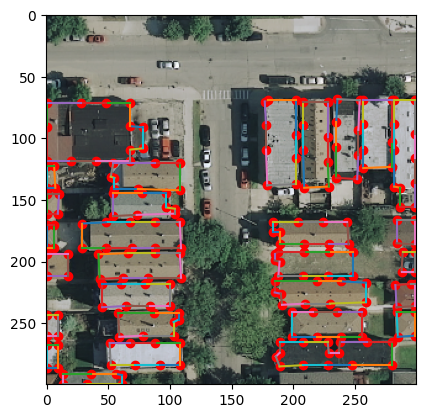

In [13]:
dataset = CrowdAI(images_directory='/nas/tsgil/dataset/Inria_building/cocostyle/images',
                    annotations_path='/nas/tsgil/dataset/Inria_building/cocostyle/annotation.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][1].detach().cpu().numpy()
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

nodes = nodes.astype('int64')

# Visualize
import matplotlib.pyplot as plt
plt.imshow(min_max_normalize(image, 0))
plt.scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
plt.show()

### DGS 모듈 더미 데이터 테스트

In [14]:
def generate_directed_adjacency_matrix(pairs_list):
    """ 주어진 노드 쌍 리스트를 기반으로 방향성 인접 행렬을 생성합니다. """
    import numpy as np

    # 인접 행렬 크기 계산 (최대 노드 인덱스 + 1)
    max_index = max(max(pair) for pair in pairs_list)
    adjacency_matrix = np.zeros((max_index + 1, max_index + 1), dtype=int)

    # 인접 행렬 채우기
    for i, j in pairs_list:
        adjacency_matrix[i, j] = 1  # 방향성 그래프: i에서 j로의 방향

    return adjacency_matrix

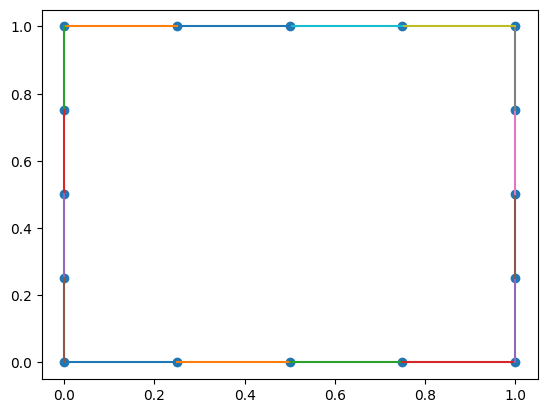

[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
[[ 6  1]
 [ 1  8]
 [ 8  4]
 [ 4 10]
 [10 11]
 [11 14]
 [14  0]
 [ 0  9]
 [ 9  2]
 [ 2  7]
 [ 7 15]
 [15  5]
 [ 5  3]
 [ 3 13]
 [13 12]
 [12  6]]


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from shapely.geometry import Polygon

from dataset_preparing import get_coords_from_densifing_points
from dataloader_cocostyle import gdf_to_nodes_and_edges

# shapes and dtypes of nodes/edges are exactly same as what I defined in InriaDataLoader

original_polygon = Polygon([(0, 0), (100, 0), (100, 100), (0, 100)])
# original_polygon = Polygon([(10, 10), (90, 10), (90, 90), (10, 90)])
gdf = gpd.GeoDataFrame(geometry = [original_polygon])

coords, gdf = get_coords_from_densifing_points(gdf, gap_distance=25)
nodes, edges = gdf_to_nodes_and_edges(gdf)
nodes = nodes / 100

nodes = nodes.astype('float32')
edges = np.array(edges).astype('int64')


# Visualizer
plt.scatter(nodes[:,1], nodes[:,0])
for e in edges:
    plt.plot(nodes[e,1], nodes[e,0])

plt.show()
print(generate_directed_adjacency_matrix(edges))
print(edges)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
{21: 2, 24: 3, 17: 4, 12: 5, 13: 7, 5: 8, 7: 10, 18: 12, 2: 13, 10: 14, 14: 15, 8: 17, 23: 18, 4: 21, 3: 23, 15: 24}
[array([0.75, 1.  ], dtype=float32), array([0.  , 0.25], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1.  ], dtype=float32), array([0.75, 1

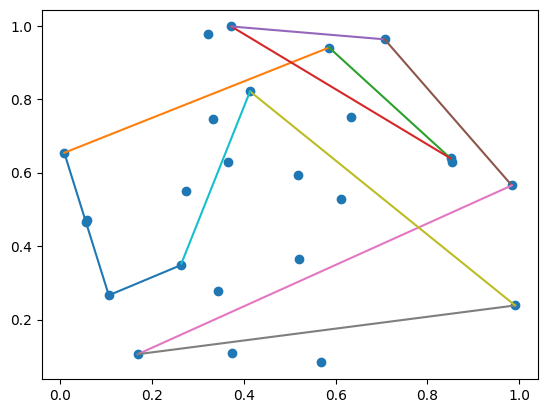

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [16]:
from models.DGS import HungarianMatcher
import torch

N = len(nodes)
K = 25

matcher = HungarianMatcher()
matcher.eval()
output = { # K개의 샘플링 뽑는 걸로 수정하기
    "pred_nodes": torch.rand(1, K, 2),
    "pred_heatmaps": torch.rand(1, 1, 320, 320),
    } # x_cord, y_cord
target = {'nodes':[torch.tensor(nodes)],
          'edges':[torch.tensor(edges)]}
out, mask, _ = matcher(output, target)
print(out[0][0])
print(out[0][1])
adj_mat = out[0]
mapping ={}
for i in range(K):
    for j in range(K):
        if adj_mat[i][j] == 1 and i != j:
            mapping[j] = i
print(mapping)
gt = [nodes[node] for node in out[0][1]]
sample = output['pred_nodes'][0]
print(gt)
print(sample[:5])
print(nodes[0],nodes[9])
print(edges[:5])
plt.scatter(sample[:,1], sample[:,0])
mapping2 = {edge[0]: edge[1] for edge in edges}
sample_edge = []
for i, j in edges:
    if i not in mapping:
        while i not in mapping:
            i = mapping2[i]
    if j not in mapping:
        while j not in mapping:
            j = mapping2[j]
    if mapping[i] != mapping[j]:
        sample_edge.append([mapping[i],mapping[j]])
for e in sample_edge:
    plt.plot(sample[e,1], sample[e,0])
plt.show()
print(generate_directed_adjacency_matrix(sample_edge))

In [17]:
sample_edge

[[17, 21],
 [21, 14],
 [14, 15],
 [15, 13],
 [13, 10],
 [10, 24],
 [24, 8],
 [8, 23],
 [23, 7],
 [7, 5],
 [5, 17]]

### TopDiG 모델 파라미터와 ckp 파일 파라미터 비교

In [18]:
import torch
import yaml
import json
from models.TopDiG import build_TopDiG
from models.backbone_R2U_Net import build_backbone
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

cp_TopDiG = torch.load('/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch8_10/models/epochs_8.pth', map_location='cpu')
cp_backbone = torch.load('/nas/tsgil/relationformer/work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10/models/epochs_130.pth', map_location='cpu')
with open('/nas/tsgil/relationformer/configs/TopDiG_train.yaml') as f:
    config1 = yaml.load(f, Loader=yaml.FullLoader)
config1 = dict2obj(config1)
with open('/nas/tsgil/relationformer/configs/inria_pretrain.yaml') as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

In [19]:
print(cp_backbone.keys())
print(cp_backbone['model_state_dict'].keys())
# print(cp_backbone['model_state_dict']['encoder.RRCNN1.RCNN.0.conv.0.weight'])

model1 = build_TopDiG(config1)
model2 = build_backbone(config2)

model1_dict = model1.state_dict()
model1_backbone_dict = model1.backbone.state_dict()
print(model1_dict.keys())
print(model1_backbone_dict.keys())
total_params = sum(p.numel() for p in model1.backbone.parameters())
print(total_params)

model2_dict = model2.state_dict()
print(model2_dict.keys())
model2.load_state_dict(cp_backbone['model_state_dict']) # , strict=False
total_params = sum(p.numel() for p in model2.parameters())
print(total_params)

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'schedulaer_state_dict'])
odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'enco

In [20]:
print(len(model1_dict.keys()), model1_dict.keys())
print(len(model2_dict.keys()), model2_dict.keys())

260 odict_keys(['backbone.encoder.RRCNN1.RCNN.0.conv.0.weight', 'backbone.encoder.RRCNN1.RCNN.0.conv.0.bias', 'backbone.encoder.RRCNN1.RCNN.0.conv.1.weight', 'backbone.encoder.RRCNN1.RCNN.0.conv.1.bias', 'backbone.encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'backbone.encoder.RRCNN1.RCNN.0.conv.1.running_var', 'backbone.encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'backbone.encoder.RRCNN1.RCNN.1.conv.0.weight', 'backbone.encoder.RRCNN1.RCNN.1.conv.0.bias', 'backbone.encoder.RRCNN1.RCNN.1.conv.1.weight', 'backbone.encoder.RRCNN1.RCNN.1.conv.1.bias', 'backbone.encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'backbone.encoder.RRCNN1.RCNN.1.conv.1.running_var', 'backbone.encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'backbone.encoder.RRCNN1.Conv_1x1.weight', 'backbone.encoder.RRCNN1.Conv_1x1.bias', 'backbone.encoder.RRCNN2.RCNN.0.conv.0.weight', 'backbone.encoder.RRCNN2.RCNN.0.conv.0.bias', 'backbone.encoder.RRCNN2.RCNN.0.conv.1.weight', 'backbone.encoder.RRCNN2.RCNN.0.conv.1.bias', 

In [21]:
if torch.equal(model1_backbone_dict['encoder.RRCNN1.RCNN.0.conv.0.weight'], model2_dict['encoder.RRCNN1.RCNN.0.conv.0.weight']):
    print('Y')

Y


In [22]:
def match_name_keywords(name, name_keywords):
    for keyword in name_keywords:
        if keyword == name.split('.')[0]:
            return True
    else: return False

cnt = 0
for n, p in model2.named_parameters():
    if match_name_keywords(n, ['encoder']):
        cnt += 1
print(cnt)
cnt = 0
for i in model2.parameters():
    cnt += 1
print(cnt)


106
112
